# Email Classifier

## Feature Engineering, Classification, Cross Validation

## The Goal
Create an Email Classifier that differentiates spam emails from normal emails ("ham").

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data
The `original_data` DataFrame contains labeled data that'll be split into training and testing the model. The 3 columns are as follows:

1. `label`: Whether the email is spam or ham
1. `email`: The contents of the email, including the subject line.
1. `label_num`: 1 if the email is spam, 0 if the email is ham (not spam)

This spam/ham data was obtained through [Kaggle and posted by Venkatesh G.](https://www.kaggle.com/datasets/venky73/spam-mails-dataset?resource=download)

In [2]:
import zipfile
with zipfile.ZipFile('archive.zip') as item:
    item.extractall()

In [3]:
original_data = pd.read_csv('spam_ham_dataset.csv')
#rename 'text' to 'email' for better readability
original_data.rename({'text': 'email'}, axis = 1, inplace = True)

# Convert the emails to lower case as a first step in text-processing
original_data['email'] = original_data['email'].str.lower()

# The unnamed column isn't necessary, and the label column is redundant
original_data = original_data.iloc[:,[2,3]]

original_data.head()

,email,label_num
0,subject: enron methanol ; meter # : 988291\r\n...,0
1,"subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: re : indian springs\r\nthis deal is t...,0


In [4]:
# Fill any missing or NAN values
original_data = original_data.fillna('')
print('Null Value Counts:')
print(original_data.isnull().sum())

Null Value Counts:
email        0
label_num    0
dtype: int64


### Training/Test Split

The idea is to use an 90/10 Train/Test split so a 10-fold cross validation can be performed afterwards. A random state of 42 is chosen to keep results comparable across runs.

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(original_data, test_size = 0.1, random_state = 42)

### Feature Engineering

The idea behind this section is that we require quantitative features in our design matrix to train our classifier. To handle the text data, the following function below `words_in_texts` will be detecting (0/1) whether a word appears in an email. 0 if the word doesn't appear in the text and 1 if the word does. 

In [6]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in 
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) (n rows, p columns) where n is the
        number of texts and p is the number of words to find.
    '''
    indicator_array = np.array([[(word in text) for word in words] for text in texts]).astype(int)
    return indicator_array

Testing it on some dummy text:

In [7]:
words_in_texts(['welcome', 'to', 'my', 'project!'], pd.Series(['welcome to deepnote', 'my project?']))

array([[1, 1, 0, 0],
       [0, 0, 1, 0]])

### EDA and Basic Classification

Using `words_in_texts(words, train['email'])`, we can try to directly train a logisitic regression model using random words and sklearn's `LogisticRegression` class.

In [8]:
some_words = ['this', 'is', 'an', 'email', 'classifier']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['label_num'])

X_train[:5], Y_train[:5]

(array([[0, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0]]),
 array([0, 1, 0, 0, 0]))

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'saga')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7214700193423598


## Feature Selection Process

The two types of features looked into were:

1. Specific words that differed between ham and spam emails.
2. Metrics such as length, alphanumeric counts, punctuation, etc. This didn't prove as fruitful.

### Evaluating Which Words to Look For

In [10]:
spams = train[train['label_num'] == 1]
hams = train[~(train['label_num'] == 1)]

In [11]:
from collections import Counter 
#we will need the counter class for below; the main metric is whether a word appeared in an email at least once 
#So, we will need to add "dictionaries" (Counter class makes it easier)

In [12]:
def appearance_to_counter(words):
    """For a given word list, words, it'll create a Counter (like dictionary, but can add values) object that stores whether it appeared or not (1 or 0).
        Note that this would mean each counter is only populated with values of 1, which is good, since we are only checking for word appearance 
        per email, not total counts.
        
        Also note that it is called words, but the list may have punctuation etc. which is still valuable for our purposes"""
    dic = {}
    for word in words:
        dic[word] = dic.get(word, 1)
    return Counter(dic)

#'words' were determined to be a series of characters being split by whitespace
hams.loc[:,'words'] = hams.loc[:,'email'].str.split()
spams.loc[:,'words'] = spams.loc[:,'email'].str.split()

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
#sample 1000 rows with replacement from each table because running the above function on ALL rows is too computationally intensive
hams_1000 = hams.sample(n = 1000, replace = True, axis = 0, random_state = 42)
spams_1000 = spams.sample(n = 1000, replace = True, axis = 0, random_state = 42)

In [14]:
hams_1000

,email,label_num,words
5117,subject: revision\r\nhuntsville / woodlands / ...,0,"[subject:, revision, huntsville, /, woodlands,..."
2561,subject: physical gas summary by desk\r\njeff ...,0,"[subject:, physical, gas, summary, by, desk, j..."
981,subject: out of the office\r\ni will be out of...,0,"[subject:, out, of, the, office, i, will, be, ..."
4280,subject: re : january nominations at shell dee...,0,"[subject:, re, :, january, nominations, at, sh..."
4075,subject: shut - in of meter 989842\r\nmeter 09...,0,"[subject:, shut, -, in, of, meter, 989842, met..."
...,...,...,...
2962,"subject: hpl noms for april 17 , 2001\r\n( see...",0,"[subject:, hpl, noms, for, april, 17, ,, 2001,..."
3734,subject: same day change - revision # 1 - hpl ...,0,"[subject:, same, day, change, -, revision, #, ..."
2698,subject: june 1 st\r\n- - - - - - - - - - - - ...,0,"[subject:, june, 1, st, -, -, -, -, -, -, -, -..."
4670,subject: resolved issue : re : meter # 0986563...,0,"[subject:, resolved, issue, :, re, :, meter, #..."


In [15]:
#getting the counts of when a word appeared at least once in an email
counter_hams = np.sum(hams_1000['words'].apply(appearance_to_counter))
counter_spams = np.sum(spams_1000['words'].apply(appearance_to_counter))

In [16]:
#finding the top differences in word appearance between ham and spam emails 
abs_differences = {key: np.abs(counter_hams.get(key, 0) - value) for key, value in counter_spams.items()}
word_counts = pd.DataFrame.from_dict(abs_differences, orient='index')
sorted_word_proportions = word_counts[0].sort_values(ascending = False)/1000 

#going to use the top 40 highest proportion difference words
words_40 = sorted_word_proportions.head(40).index

In [17]:
#Evaluate which words are the best 
#Chose L1 loss for feature selection
X_train = words_in_texts(words_40, train['email'])
Y_train = np.array(train['label_num'])

lr_words = LogisticRegression(penalty = 'l1', solver = 'saga')
lr_words.fit(X_train, Y_train)

#We want absolute weights because we are only interested in seeing the most important features
abs_weights = np.abs(lr_words.coef_[0])
feature_weights = {feature:weight for feature, weight in zip(words_40, abs_weights)} 

In [18]:
#evaluating the predictions:
predictions = lr_words.predict(X_train)
train_accuracy = sum(predictions == Y_train)/len(predictions) #0.9138826034872887

train_accuracy

0.9256393724478831

### Getting Rid of Correlated Features

In [19]:
#Out of curiousity to see which features are most important
#sorting the dictionary by weight magnitude (decreasing order)

values = list(feature_weights.values())
values.sort(reverse = True)
sorted_dict = {}

for value in values:
    for k in feature_weights.keys():
        if feature_weights[k] == value:
            sorted_dict[k] = feature_weights[k]
            break

#note, this sorting method will lead to some of the 0s going away, but that's okay because we don't need the 0 weighted features
len(sorted_dict) 

38

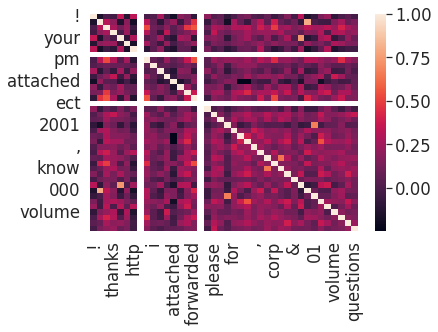

In [20]:
feature_df = pd.DataFrame(data = X_train, columns = words_40) #checking corr. using the training set!

def remove_correlated(feature_data, corr_threshold = 0.9):
    """Removes highly correlated features (and chooses one of them) for the correlation matrix. Returns an updated correlation matrix."""
    #you just need to check the bottom half (triangle) of the corr matrix; the rest are repeats. Can ignore the 1s diagnal as well
    corr_features = set()
    corr_matrix = feature_data.corr()
    
    for row in range(len(corr_matrix.columns)):
        for col in range(row):
            if np.abs(corr_matrix.iloc[row, col]) > corr_threshold: #if this is true, remove one feature
                column = corr_matrix.columns[row]
                corr_features.add(column) #this already won't add duplicates; and since we are just adding from one axis, it won't get rid of both correlated features
                #another way to do this would be to drop columns... but thats complicated bc we are iterating on a fixed number of rows which = columns etc.
    return feature_data.drop(labels = corr_features, axis = 1)

filtered_df = remove_correlated(feature_df)
filtered_df.shape #looks like it removed 11 features!

#We see that the heatmap is pretty messy; so lets clean up the dataframe with filtering using the correlation matrix
#sns.heatmap(feature_df.corr()) #this is what it was before; there are a lot of light spots/white which indicates high correlation (according to the legend)
sns.heatmap(filtered_df.corr()); #this is how it looks like after removing correlations > 0.9!

#Note, this graph will also be shown in 2a

In [21]:
#creating a new model after removing highly correlated features
X_train = filtered_df.values

lr_words_improved = LogisticRegression(penalty = 'l1', solver = 'saga')
lr_words_improved.fit(X_train, Y_train)

LogisticRegression(penalty='l1', solver='saga')

In [22]:
#evaluating the predictions:
predictions = lr_words_improved.predict(X_train)
train_accuracy = sum(predictions == Y_train)/len(predictions) #0.9138826034872887

train_accuracy

0.9256393724478831

### K-Fold Cross Validation
We are using this method since only using the given sets above to choose a hyperparameter led to likely a bias towards the given validation set (which ended up worsening my testing accuracy). We are choosing K = 10. 

In [23]:
from sklearn.model_selection import KFold

We'll be using this function to output our model as well as its performance.

In [25]:
def make_model(X_train, X_val, Y_train, Y_val, non_word_features = None):
    """For the given correlation coefficient threshold (when to determine when to remove redundant/correlated features), return
        validation set accuracy, the model created, and the features of used in that model, in that order."""
    
    if non_word_features:
        df_X = pd.DataFrame(data = X_train)
        df_X = df_X.join(non_word_features, left_on = True, right_on = True)
        X_train = df_X.values
    
    lr_model_1 = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=500)
    lr_model_1.fit(X_train, Y_train)
    
    predictions = lr_model_1.predict(X_val) #0.9054
    val_accuracy = sum(predictions == Y_val)/len(predictions)

    return val_accuracy, lr_model_1, filtered.columns

Example usage:

In [26]:
best_acc = 0
best_threshold = -1
corr_thresholds = np.linspace(0.8, 1, num = 21)

#using an example validation set to show functionality -- this won't be what is 
#actually used in tuning hyperparams
val, _ = train_test_split(test, test_size = 0.5, random_state = 42)

Y_val = val['label_num']

for threshold in corr_thresholds:
    filtered = remove_correlated(feature_df, corr_threshold = threshold)
    X_train = filtered.values
    X_val = words_in_texts(filtered.columns, val['email'])
    
    curr_acc, curr_model, curr_features = make_model(X_train, X_val, Y_train, Y_val) 
    
    if curr_acc > best_acc:
        best_threshold = threshold
        best_acc = curr_acc
        best_model = curr_model
        best_features = curr_features

In [27]:
best_acc, best_threshold

(0.9073359073359073, 0.8)

In [52]:
#steps: remove correlated features according to a threshold, then get the X_train, X_val. Train a model using X_train and check the accuracy of X_val, then store that
#for the k-fold validation, get the average accuracies of the 5 folds (we choose k = 5) at each hyperparam (0.8 -- 1 linspace 20?)  
#we will still use words_40 as the initial starting features even though during this K-fold cross validation, the training and validation sets change
#this is because the process of choosing the 40 words is quite intensive, and will likely be similar across all sets. 

def average_of_k_folds(corr_threshold, data = original_data, k = 10):
    """Perform K_fold cross validation for the given corr_threshold"""
    
    kf = KFold(n_splits = k, shuffle = True, random_state = 42)
    accuracies = []
    
    X = words_in_texts(words_40, original_data['email'])
    Y = original_data['label_num']
    
    
    for train_index, val_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", val_index)
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        #have to have this in a dataframe first because we will be removing highly correlated features based on the training set
        feature_train_df = pd.DataFrame(data = X_train, columns = words_40)
        feature_val_df = pd.DataFrame(data = X_val, columns = words_40)
        
        filtered = remove_correlated(feature_train_df, corr_threshold = corr_threshold)
        X_train = filtered.values
        X_val = feature_val_df.loc[:, filtered.columns].values
        
        curr_acc = make_model(X_train, X_val, Y_train, Y_val)[0] #in this case we aren't really using the other outputs for now
        
        accuracies.append(curr_acc)
    
    return np.mean(accuracies)

In [29]:
#Time to cross validate! Give the best corr_threshold value based on validation set accuracy

for threshold in corr_thresholds:
    curr_acc = average_of_k_folds(corr_threshold = threshold)
    
    if curr_acc > best_acc:
        best_acc = curr_acc
        best_threshold = threshold
        

In [30]:
best_threshold

0.8

Looks like the best threshold was the lower bound of our initial guess of "optimal thresholds"! Let's try lower.

In [32]:
corr_thresholds_2 = np.linspace(0.7, 0.8, num = 11)

#Time to cross validate! Give the best corr_threshold value based on validation set accuracy

for threshold in corr_thresholds_2:
    curr_acc = average_of_k_folds(corr_threshold = threshold)
    
    if curr_acc > best_acc:
        best_acc = curr_acc
        best_threshold = threshold

In [34]:
best_acc, best_threshold

(0.921679125934445, 0.8)

Looks like 0.8 was the best correlation cutoff across all cross validation averages!

### Features Besides Just Words
Included this just to show my process; however, choosing features besides words did not bear any fruit for me. As a result, none of the features below were used in the final model (except the "\<html\>" tag, which is in the words list above.

In [36]:
#add features

for df in [train, val]:
    df['email_length']  = df['email'].str.len()
    non_alphanumeric = df['email'].str.lower().str.extractall(r"([^a-z0-9\s]+)")
    df['non_alphanumeric count'] = non_alphanumeric.reset_index().groupby('level_0')[0].count()
    df['is_reply?'] = df['email'].str.lower().str.contains("subject: re:").astype(int)
    df['has_html'] = df['email'].str.lower().str.contains(r"<html>").astype(int)
    exclamations = df['email'].str.lower().str.extractall(r"(!)")
    df['num_!'] = exclamations.reset_index().groupby('level_0')[0].count()
    
    questions = df['email'].str.lower().str.extractall(r"(\?)")
    df['num_?'] = questions.reset_index().groupby('level_0')[0].count()
    
train = train.fillna(0)
val = val.fillna(0)

In [37]:
features = train.columns[4:]
features

Index(['is_reply?', 'has_html', 'num_!', 'num_?'], dtype='object')

In [38]:
len(features)

4

In [39]:
#based on the dt it seems pretty good but lets try something else 
validation_accuracies = []

for i in range(len(features)):
    X_train = train[[features[i]]]
    y_train = train['label_num']

    X_val = val[[features[i]]]
    y_val = val['label_num']

    log_model = LogisticRegression(random_state = 42) 
    log_model.fit(X_train, y_train)
    predictions = log_model.predict(X_val)
    num_corr = sum(predictions == y_val)
    validation_accuracies.append(num_corr/len(y_val))
    
validation_accuracies
#out of all the singular features, the 'has_html' one leads to the best accuracy improvement of 0.8311 validation accuracy
#also note that checking for html worked better than just getting all <>
#the rest still don't seem to work
#as a result, this has led to me to just take a look at word content and use that

[0.7142857142857143,
 0.7142857142857143,
 0.7451737451737451,
 0.7142857142857143]

In [40]:
#Looking at the accuracy for guessing all 0s on the validation set
all_0s_correct = sum(0 == y_val)

prop_0 = all_0s_correct/len(y_val)

prop_0

0.7142857142857143

### The Final Model
This is what will be used for the test set predictions.

In [41]:
feature_df.head()

,!,2000,cc,thanks,your,gas,http,subject,pm,i,...,&,our,000,01,the,com,volume,farmer,will,questions
0,0,1,1,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,1,0,0
1,1,0,0,0,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,1,0,0,0,1
3,0,1,0,0,0,0,0,1,1,1,...,0,0,1,1,1,1,0,1,1,0
4,0,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,1,0,1,0


In [42]:
#best_threshold was defined above in the "K-fold Cross Validation" question
filtered = remove_correlated(feature_df, corr_threshold = best_threshold)

X_train = filtered.values
X_val = words_in_texts(filtered.columns, val['email'])
    
best_acc, best_model, best_features = make_model(X_train, X_val, Y_train, Y_val) 

In [46]:
best_acc

0.9073359073359073

### Visualizations
A visual representation of the insight put into feature selection.

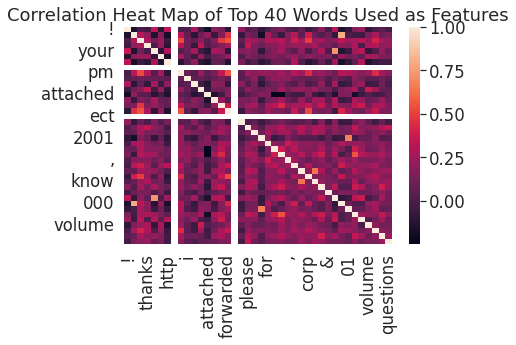

In [47]:
feature_df = pd.DataFrame(data = X_train, columns = words_40) #checking corr. using the training set!

#code is repasted from above for convenience in grading
def remove_correlated(feature_data, corr_threshold = 0.9):
    """Removes highly correlated features (and chooses one of them) for the correlation matrix. Returns an updated correlation matrix."""
    #you just need to check the bottom half (triangle) of the corr matrix; the rest are repeats. Can ignore the 1s diagnal as well
    corr_features = set()
    corr_matrix = feature_data.corr()
    
    for row in range(len(corr_matrix.columns)):
        for col in range(row):
            if np.abs(corr_matrix.iloc[row, col]) > corr_threshold: #if this is true, remove one feature
                column = corr_matrix.columns[row]
                corr_features.add(column) #this already won't add duplicates; and since we are just adding from one axis, it won't get rid of both correlated features
                #another way to do this would be to drop columns... but thats complicated bc we are iterating on a fixed number of rows which = columns etc.
    return feature_data.drop(labels = corr_features, axis = 1)

sns.heatmap(feature_df.corr()) #this is what it was before; there are a lot of light spots/white which indicates high correlation (according to the legend)
plt.title('Correlation Heat Map of Top 40 Words Used as Features');

In [ ]:
#If we try removing correlated features
filtered_df = remove_correlated(feature_df, 0.8)
filtered_df.shape 

(4653, 40)

As shown above, no features were removed led to the best accuracy for the model. The heatmap showed that across all features, not many were too highly correlated -- the upperbound of correlation coefficients was 0.8, as that proved to be the best threshold (in the previous section).

### ROC Curve
A trade-off between True Positive Rates and False Positive 

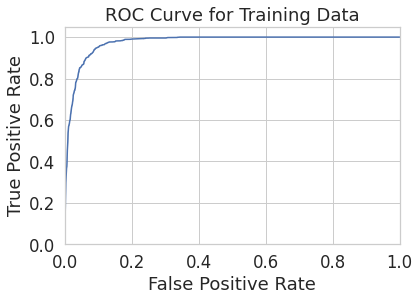

In [54]:
from sklearn.metrics import roc_curve

y_proba = best_model.predict_proba(X_train)[:, 1] #grabs the y_probabilities
fpr, tpr, _= roc_curve(Y_train, y_proba)

sns.lineplot(x = fpr, y = tpr)
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve for Training Data');

## Test Predictions

Let's test our accuracy!

In [56]:
X_test = words_in_texts(best_features, test['email'])
test_predictions = best_model.predict(X_test)

accuracy = sum(test_predictions == test['label_num'])/test_predictions.shape[0]
accuracy

0.918918918918919

That concludes this section of the Logisitc Regression Email Classifier. Further analysis can be done using Vader sentiment analysis -- stay tuned.

## Random Forest

For fun, lets see how much better a Random Forest Model fares compared to the logistic regression classifier. TO BE CONTINUED

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f27f84c3-3a8f-418e-a519-ea499750e71c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>